In [1]:
# %load_ext kedro.extras.extensions.ipython
# %reload_kedro /home/ofurman/Probabilistic-Flow-Boosting

In [2]:
import sys
sys.path.append("../src/")

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import umap

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer

from probabilistic_flow_boosting.models.nodeflow import NodeFlow, NodeFlowDataModule
from probabilistic_flow_boosting.models.node_gmm import NodeGMM
from probabilistic_flow_boosting.extras.datasets.uci_dataset import UCIDataSet
from probabilistic_flow_boosting.pipelines.modeling.nodes.nodeflow import train_nodeflow

In [3]:
def plot_embeddings_on_single_figure(x_train, y_train, embedding_functions, model_names, models):
    # Create a figure explicitly
    fig, axes = plt.subplots(1, len(embedding_functions), figsize=(15, 5), sharey=True)
    
    for i, (embed_function, model) in enumerate(zip(embedding_functions, models)):
        X_embeddings = embed_function(model, x_train)
        tr = umap.UMAP(n_components=2)
        X_umap = tr.fit_transform(X_embeddings)

        ax = axes[i]
        sc = ax.scatter(X_umap[:, 0], X_umap[:, 1], c=y_train, cmap='viridis', alpha=0.75)
        ax.set_title(f'Embeddings using {model_names[i]}')
        ax.set_xlabel('UMAP Dimension 1')

        if i == 0:
            ax.set_ylabel('UMAP Dimension 2')

        # Set major tick locators to integer values
        ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

    return fig


def embed_cnf(model, X: torch.Tensor):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    X = scaler.fit_transform(X)
    return X


def embed_cnf_mlp(model, X: torch.Tensor):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    
    X = scaler.fit_transform(X)
    X = torch.Tensor(X)
    
    embeddings = model.feature_extractor(X).detach().numpy()
    return embeddings


def embed_nodeflow(model: NodeFlow, X: torch.Tensor):
    feature_scaler = Pipeline(
        [
            ("quantile", QuantileTransformer(output_distribution="normal")),
            ("standarize", StandardScaler()),
        ]
    )
    X = feature_scaler.fit_transform(X)
    X = torch.Tensor(X)
    
    grad_x = X.clone().requires_grad_()
    x = model.tree_model(grad_x)
    embeddings = x.detach().numpy()
    return embeddings

In [4]:
uci_datasets = [
    'concrete', 
    'energy', 
    'kin8nm', 
    'naval-propulsion-plant', 
    'power-plant', 
    'protein-tertiary-structure', 
    'wine-quality-red', 
    'yacht'
]

concrete


/opt/homebrew/anaconda3/envs/nodeflow/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (927). n_quantiles is set to n_samples.
  warnings.warn(


energy


/opt/homebrew/anaconda3/envs/nodeflow/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (691). n_quantiles is set to n_samples.
  warnings.warn(


kin8nm
naval-propulsion-plant
power-plant
protein-tertiary-structure
wine-quality-red
yacht


/opt/homebrew/anaconda3/envs/nodeflow/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (277). n_quantiles is set to n_samples.
  warnings.warn(


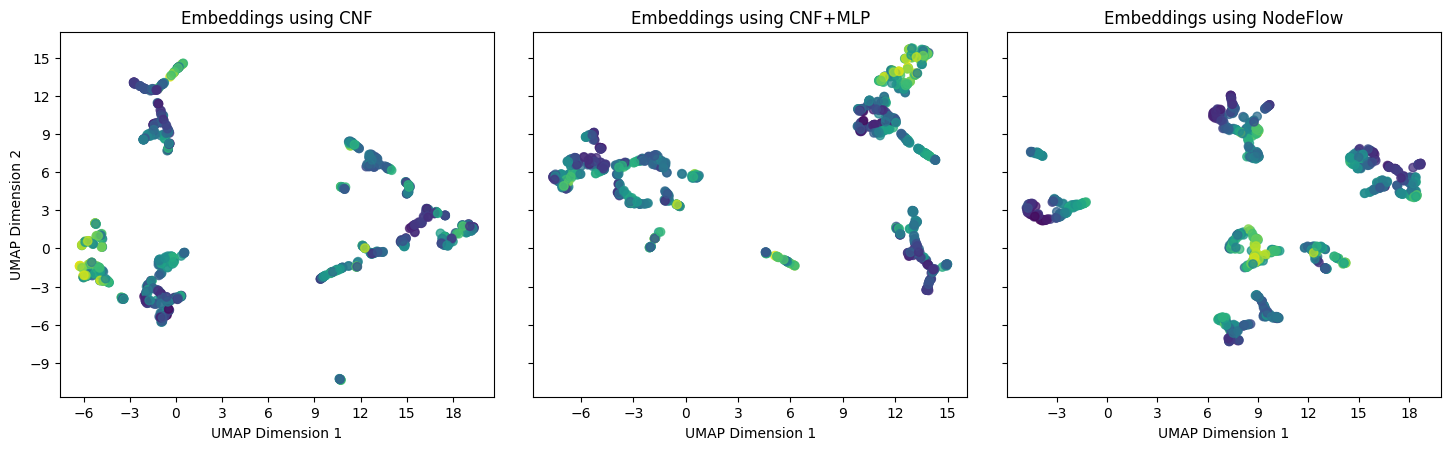

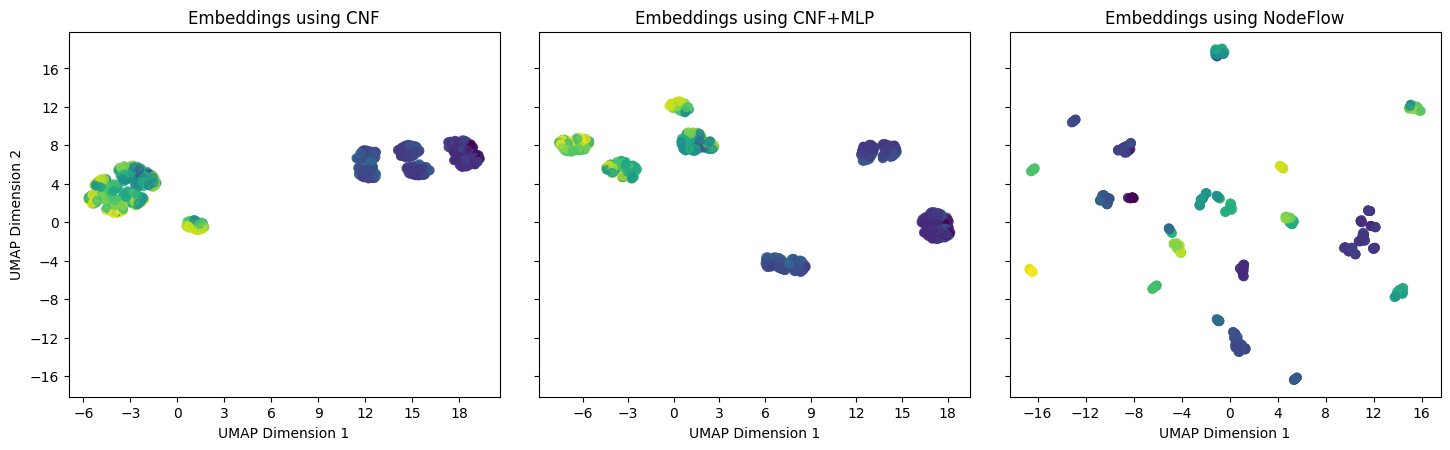

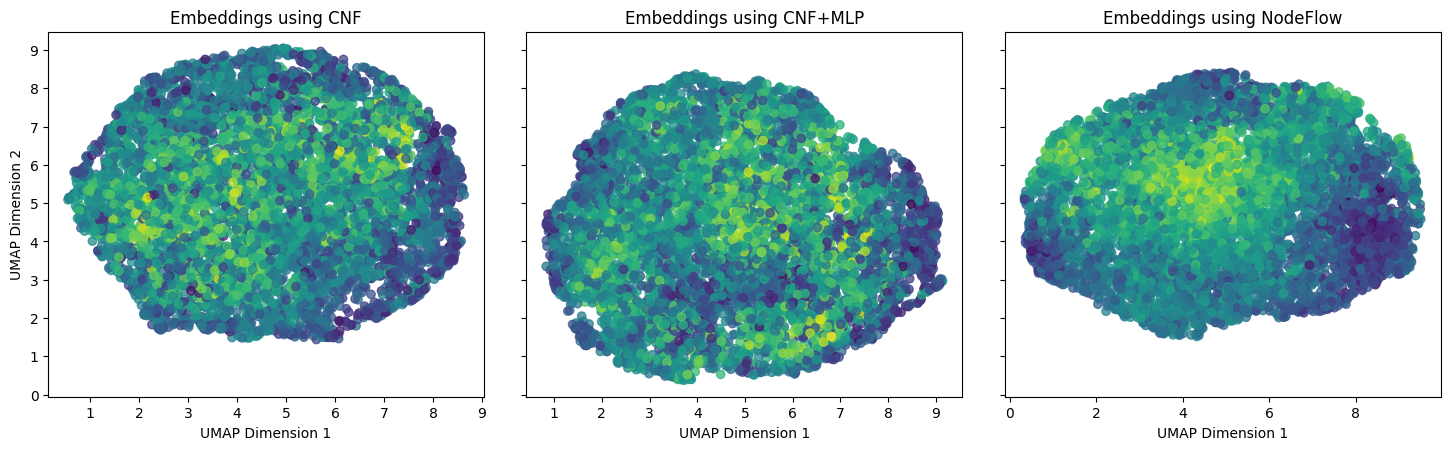

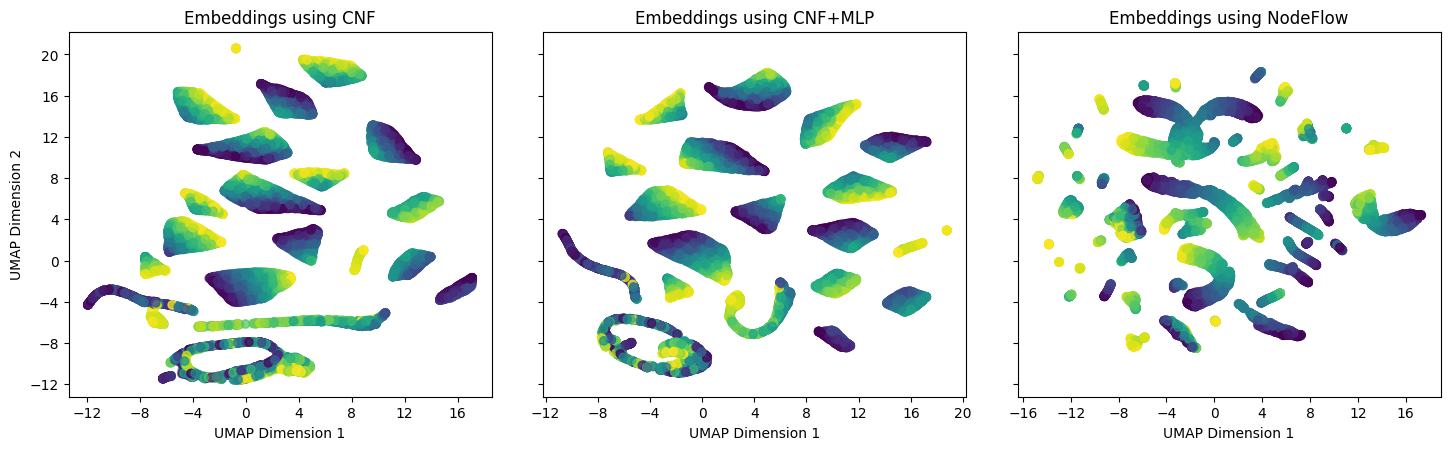

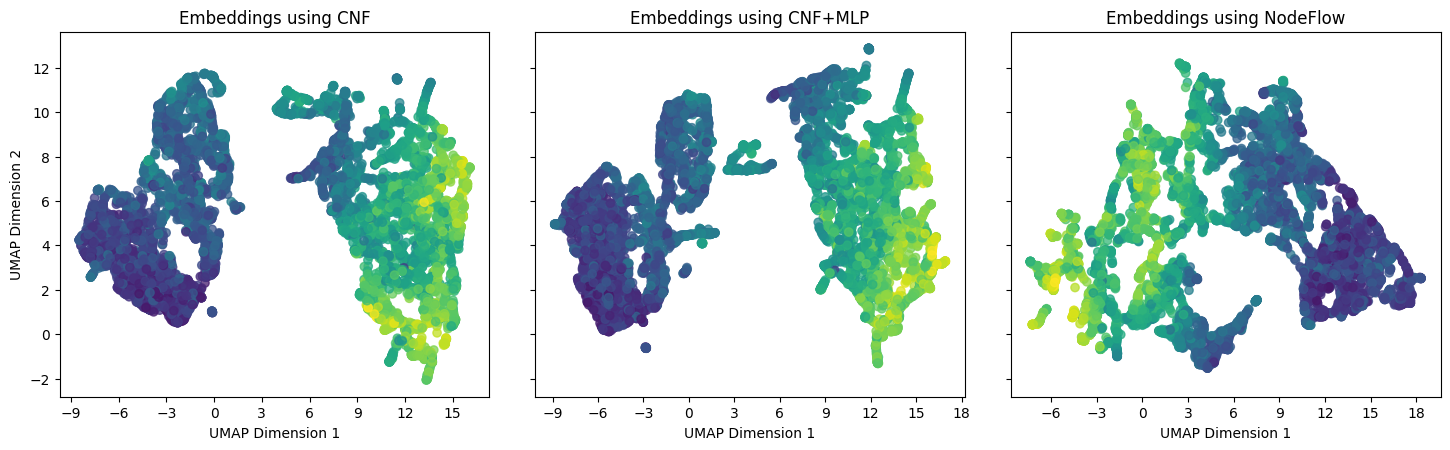

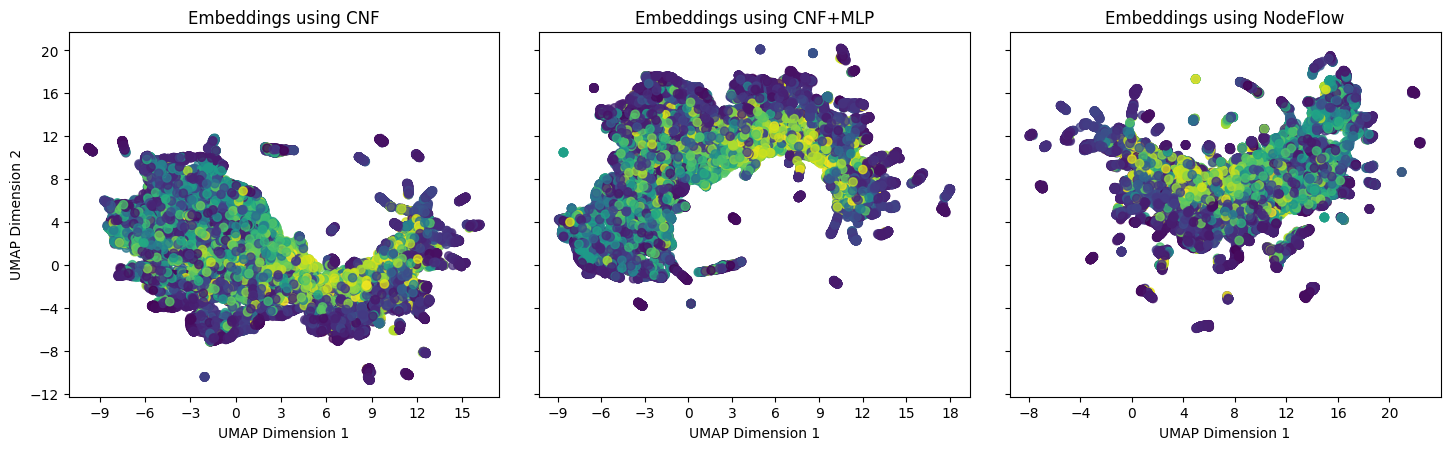

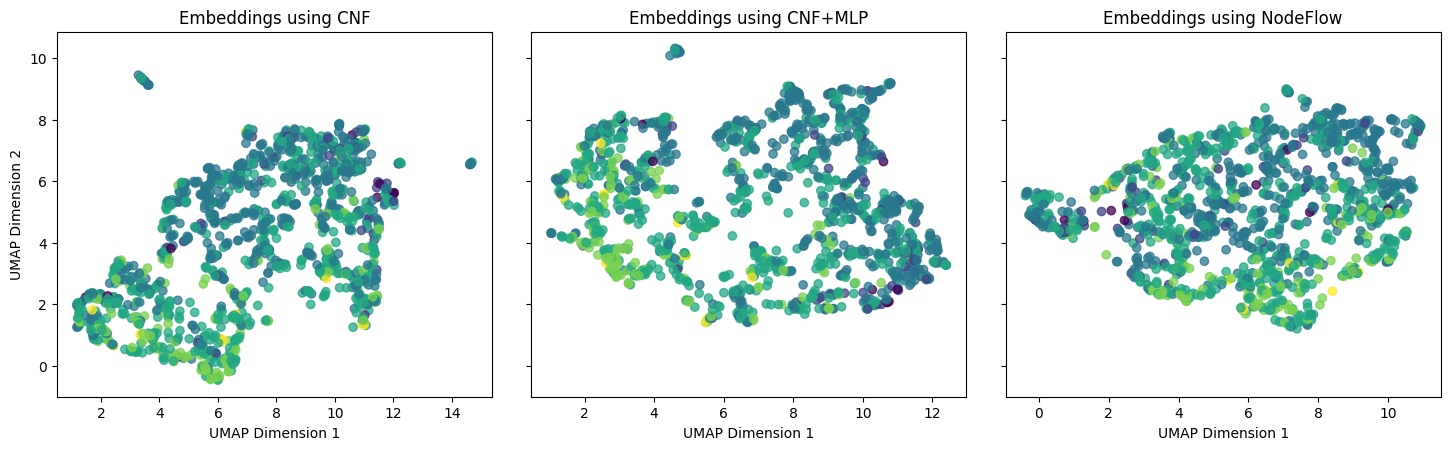

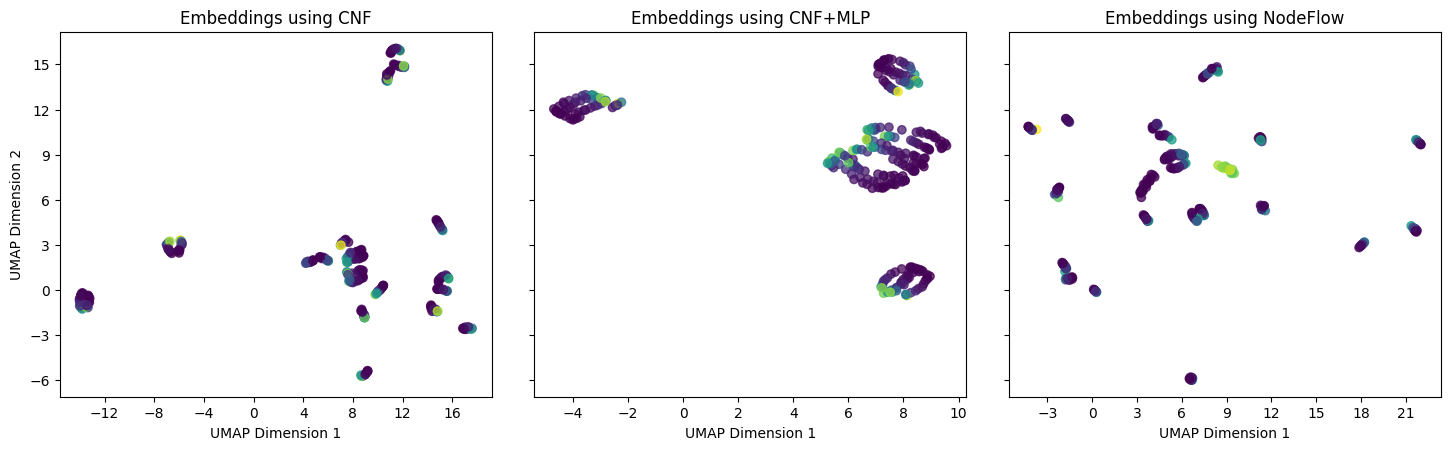

In [5]:
for DATASET in uci_datasets:
    IDX = 0
    print(DATASET)
    
    ## Load data
    x_train = UCIDataSet(
        filepath_data=f"../data/01_raw/UCI/{DATASET}/data.txt",
        filepath_index_columns=f"../data/01_raw/UCI/{DATASET}/index_features.txt",
        filepath_index_rows=f"../data/01_raw/UCI/{DATASET}/index_train_{IDX}.txt"
    ).load()
    y_train = UCIDataSet(
        filepath_data=f"../data/01_raw/UCI/{DATASET}/data.txt",
        filepath_index_columns=f"../data/01_raw/UCI/{DATASET}/index_target.txt",
        filepath_index_rows=f"../data/01_raw/UCI/{DATASET}/index_train_{IDX}.txt"
    ).load()

    x_train_tensor = torch.Tensor(x_train.values)
    y_train_tensor = torch.Tensor(y_train.values)

    ## Load models
    model_filepath = f"../models/cnf_mlp/UCI/{DATASET}/model_cnf_{IDX}-cnf.pt"
    cnf_mlp = torch.load(model_filepath, map_location="cpu")

    model_filepath = f"../models/nodeflow_x/UCI/{DATASET}/model_x_0"
    nodeflow = NodeFlow.load(model_filepath, map_location="cpu")
    nodeflow.eval()

    ## Do things
    embedding_functions = [embed_cnf, embed_cnf_mlp, embed_nodeflow]
    model_names = ["CNF", "CNF+MLP", "NodeFlow"]
    models = [None, cnf_mlp, nodeflow]
    
    plot_embeddings_on_single_figure(x_train_tensor, y_train_tensor, embedding_functions, model_names, models)

    plt.tight_layout(pad=2.5)
    plt.savefig(f"../figures/{DATASET}.pdf")
